# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [9]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [10]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

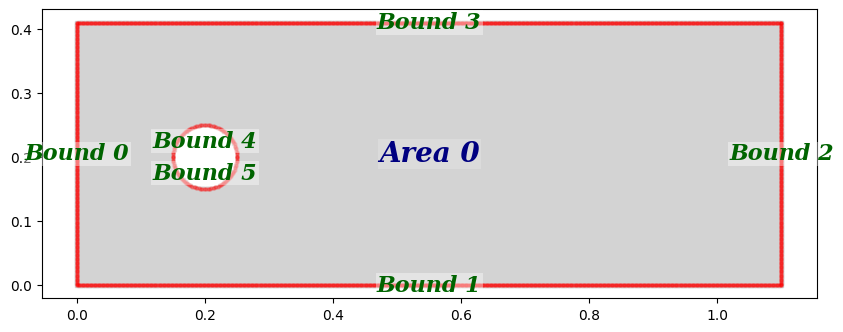

In [11]:
domain = df.domain(rectangle.bound_list, circle.bound_list, area)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

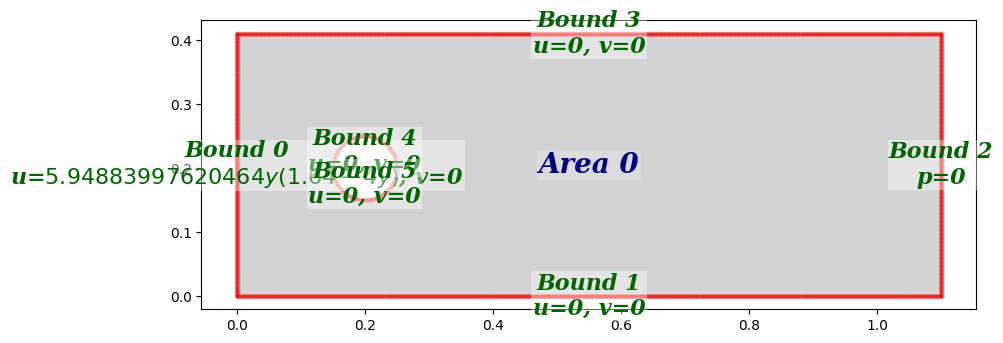

In [12]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

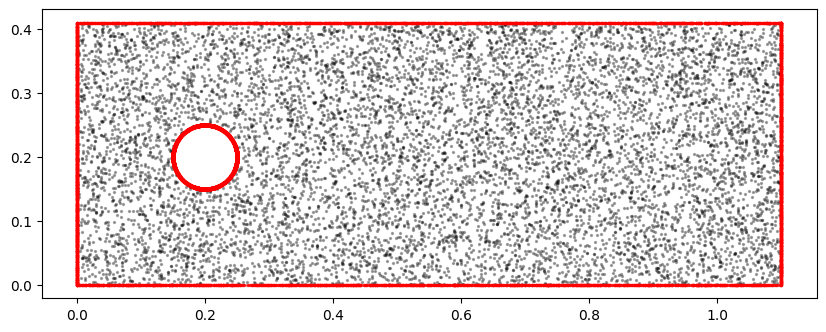

In [ ]:
domain.sampling_random(bound_sampling_res=[2000, 2000, 2000, 2000, 4000, 4000])
domain.sampling_random(area_sampling_res=[10000])
domain.show_coordinates(display_conditions=False)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [14]:
model0 = df.PINN(width=50, length=5)

Design how to compute loss from boundary conditions and PDE residuals

In [ ]:
# Define the loss calculation function
def calc_loss(model):
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [16]:
# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.001,
    epochs=2000,
    calc_loss=calc_loss,
    print_every=200,
    threshold_loss=0.001
)

Epoch: 1, total_loss: 0.59434, bc_loss: 0.59420, pde_loss: 0.00014
Epoch: 200, total_loss: 0.28418, bc_loss: 0.26358, pde_loss: 0.02060
Epoch: 400, total_loss: 0.21307, bc_loss: 0.18209, pde_loss: 0.03098
Epoch: 600, total_loss: 0.19841, bc_loss: 0.16916, pde_loss: 0.02925
Epoch: 800, total_loss: 0.19440, bc_loss: 0.16466, pde_loss: 0.02974
Epoch: 1000, total_loss: 0.18487, bc_loss: 0.15431, pde_loss: 0.03057
Epoch: 1200, total_loss: 0.17595, bc_loss: 0.14599, pde_loss: 0.02996
Epoch: 1400, total_loss: 0.15963, bc_loss: 0.13310, pde_loss: 0.02653
Epoch: 1600, total_loss: 0.13959, bc_loss: 0.11673, pde_loss: 0.02286
Epoch: 1800, total_loss: 0.12642, bc_loss: 0.10707, pde_loss: 0.01934
Epoch: 2000, total_loss: 0.11923, bc_loss: 0.09890, pde_loss: 0.02033


Refine the model using LBFGS for higher precision.

In [ ]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    threshold_loss=0.00001)

Epoch: 1996, total_loss: 0.11358, bc_loss: 0.09373, pde_loss: 0.01985
Epoch: 2046, total_loss: 0.00704, bc_loss: 0.00238, pde_loss: 0.00466
Epoch: 2096, total_loss: 0.00205, bc_loss: 0.00056, pde_loss: 0.00149
Epoch: 2146, total_loss: 0.00112, bc_loss: 0.00030, pde_loss: 0.00082
Epoch: 2196, total_loss: 0.00071, bc_loss: 0.00019, pde_loss: 0.00052
Epoch: 2246, total_loss: 0.00052, bc_loss: 0.00016, pde_loss: 0.00036
Epoch: 2296, total_loss: 0.00040, bc_loss: 0.00013, pde_loss: 0.00028
Epoch: 2346, total_loss: 0.00033, bc_loss: 0.00011, pde_loss: 0.00022
Epoch: 2396, total_loss: 0.00028, bc_loss: 0.00010, pde_loss: 0.00019
Epoch: 2446, total_loss: 0.00024, bc_loss: 0.00009, pde_loss: 0.00015


Save or Load the model for later use

In [18]:
model2.save_as_pickle()
model2.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [19]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([300, 200])

Available data keys: ('u', 'v', 'p', 'PDE residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


In [20]:
area_eval["velocity_magnitude"] = (area_eval["u"]**2 + area_eval["v"]**2)**0.5

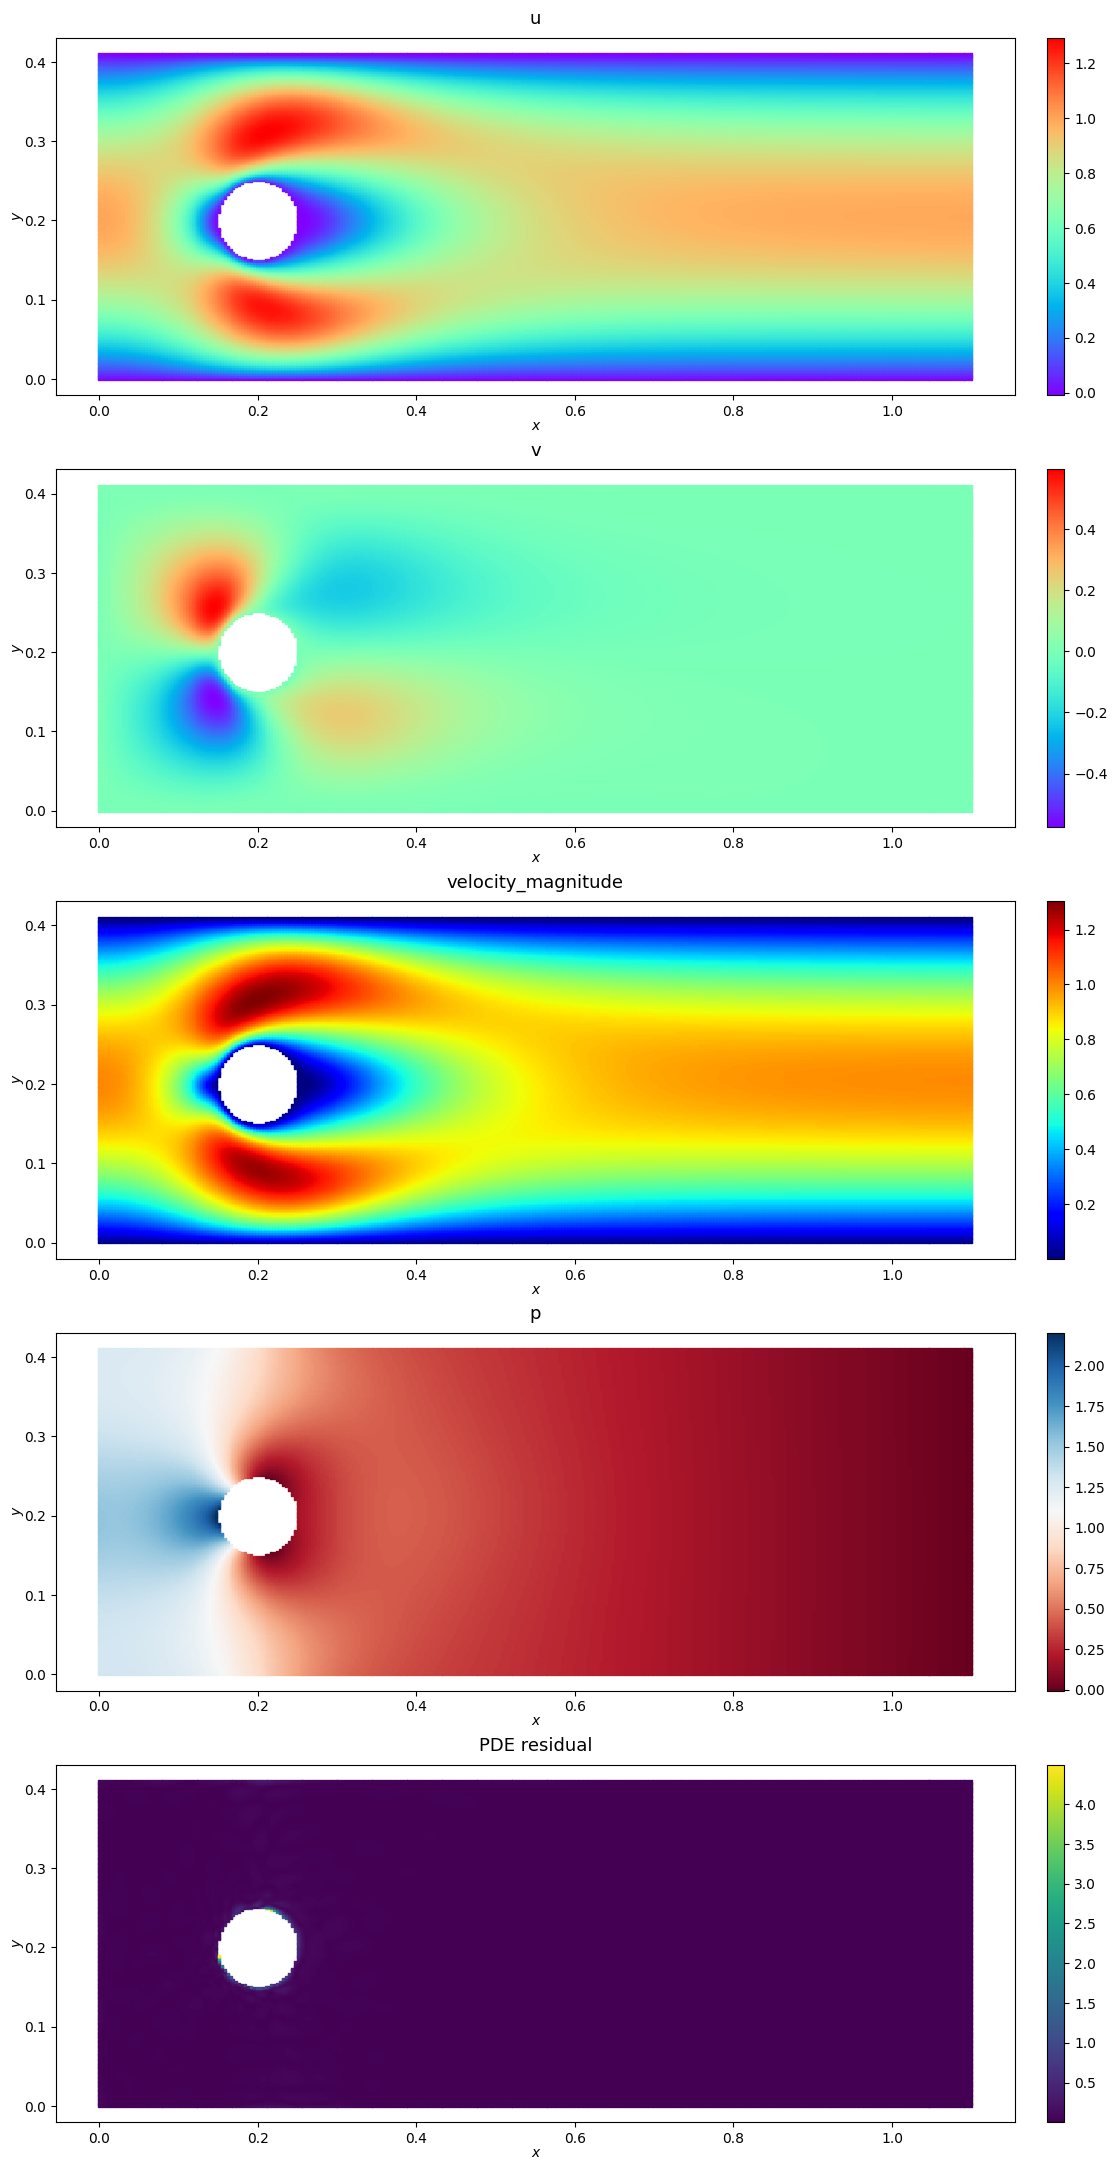

In [21]:
cmap_dict = {
    'u':'rainbow',
    'v':'rainbow',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=2).savefig("colorplot_2d")

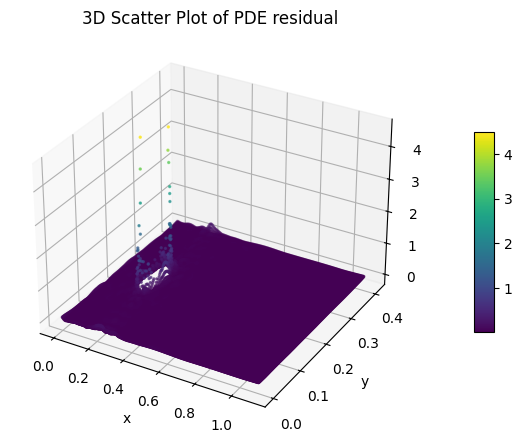

In [22]:
residual_plot_3d = area_eval.plot('PDE residual').savefig("residual_plot_3d.png")

### 4.2 Visualize bound

In [28]:
# Create object for evaluation
bound_visual = domain.bound_list[2].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(200)

Available data keys: ('u', 'v', 'p', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\deepflow\src\deepflow\visualization.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.ptp(self.Y) / np.ptp(self.X)


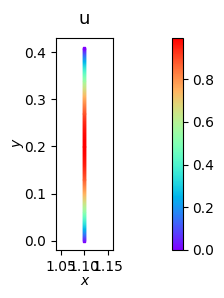

In [29]:
colorplot_bound = bound_visual.plot_color({'u':'rainbow'}).savefig("colorplot_bound.png")

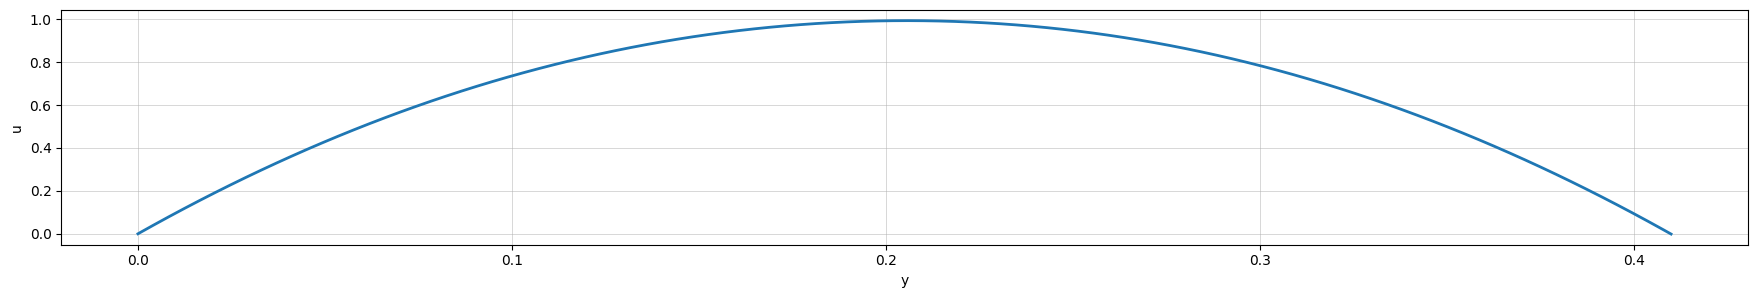

In [30]:
velocity_plot_outlet = bound_visual.plot('u', axis='y').savefig("plot_outlet_velocity.png")

## 4.3 Visualize Neural Network data

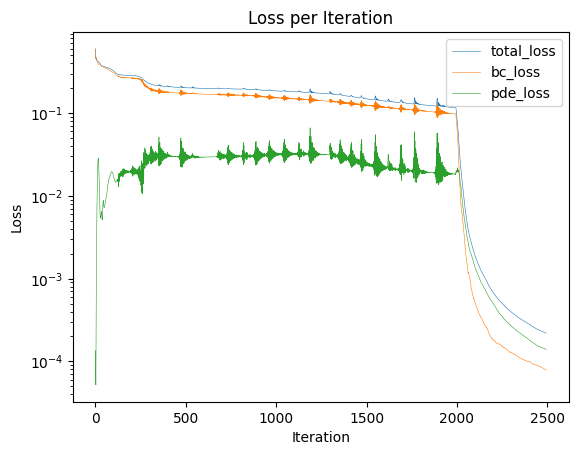

In [31]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4).savefig("loss_history.png")

### 4.4 Export data

In [32]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)